#NN Final Project
##[Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802)
##Students
 - Weihao Wang(1988339)
 - jithin kumar palepu(2022404) 


## Background

For recover the finer texture details
when we super-resolve at large upscaling factors, the authors propose a  Super-Resolution Generative Adversarial
Network .They first train a super-resolution residual network (SRResNet) with standard pixel-wise loss that achieves state-of-the-art metrics. Then insert this as the generator in the SRGAN framework, which is trained with a combination of pixel-wise, perceptual, and adversarial losses. In a word, they trained their model for estimating optimal parameters to minimize the loss function they provied, which is 

\begin{align*}
    \hatθ_G=\underset{θ_G}{\operatorname{argmin}}\frac{1}{N}\sum_{n=1}^{N}{l^{SR}(G_{\theta_G}(I^{LR}_n),I^{HR}_n)}
\end{align*}

## My Works
- Image processing and augmentation with [STL10 dataset](https://cs.stanford.edu/~acoates/stl10).
- Reimplement the architecture of SRResNet as part of SRGAN and for comparison 
- Reimplement the architecture of SRGAN 
- Reimplement the architecture of Perceptual loss function
- Train SRResNet with MSE loss; Train SRGAN with Perceptual loss function
- Use benchmarks provided by the paper to verify and compare the results of our reimplement model.






##Data Processing
Import the STL10 dataset and transform  images of dataset.
Scaling factor is four times s.t.\begin{align*}
   r=4×
\end{align*}


In [ ]:
import torch
import math
from PIL import Image
import numpy as np
import torchvision
import torchvision.transforms as transforms
from google.colab import drive
from torch.autograd import Variable
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Dataset(torchvision.datasets.STL10):
    '''
    Dataset Class
    Implements a dataset class for STL10 
    Values:
        hr_size: spatial size of high-resolution image, a list/tuple
        lr_size: spatial size of low-resolution image, a list/tuple
        *args/**kwargs: all other arguments for subclassed torchvision dataset
    '''

    def __init__(self, *args, **kwargs):
        #Default size
        hr_size = kwargs.pop('hr_size', [96, 96])
        lr_size = kwargs.pop('lr_size', [24, 24])
        super().__init__(*args, **kwargs)

        if hr_size is not None and lr_size is not None:
            assert hr_size[0] == 4 * lr_size[0]
            assert hr_size[1] == 4 * lr_size[1]

        # High-res images are cropped and scaled to [-1, 1]
        self.hr_transforms = transforms.Compose([
            transforms.RandomCrop(hr_size),
            transforms.RandomHorizontalFlip(),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        # Low-res images are downsampled with bicubic kernel and scaled to [0, 1]
        self.lr_transforms = transforms.Compose([
            transforms.Normalize((-1.0, -1.0, -1.0), (2.0, 2.0, 2.0)),
            transforms.ToPILImage(),
            transforms.Resize(lr_size, interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])

        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()


    def _len_(self):
      return len(self.data)

    def __getitem__(self, idx):

        image = torch.from_numpy(self.data[idx])
        image = self.to_pil(image)

        hr = self.hr_transforms(image)
        lr = self.lr_transforms(hr)
        return hr, lr

    @staticmethod
    def collate_fn(batch):
        hrs, lrs = [], []

        for hr, lr in batch:
            hrs.append(hr)
            lrs.append(lr)

        return torch.stack(hrs, dim=0), torch.stack(lrs, dim=0) 


In [ ]:
Thisdataset=Dataset('data', 'train', download=True, hr_size=[96, 96], lr_size=[24, 24])

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting data/stl10_binary.tar.gz to data


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
dataloader = torch.utils.data.DataLoader(Thisdataset,batch_size=16,shuffle=True,pin_memory=True)

##Generator (SRResNet)

The general idea behind this formulation is that it allows
one to train a generative model G with the goal of fooling a
differentiable discriminator D that is trained to distinguish
super-resolved images from real images.

The generator network architecture is made up of a bunch of residual blocks which are constructed from two convolutional layers with small 3×3 kernels and 64
feature maps followed by batch-normalization layers and ParametricReLU  as the activation function. And employed two trained
sub-pixel convolution layers to increase the resolution of the input image.

> ![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Generator.png?raw=true)
*SRGAN Generator, taken from Figure 4 of [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (Ledig et al. 2017).*

###Residual Blocks

A residual block from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) (He et al. 2015) is a stack of layers set in such a way that the output of a layer is taken and added to another layer deeper in the block. The non-linearity is then applied after adding it together with the output of the corresponding layer in the main path.


### Parametric ReLU (PReLU)

ReLU is one of the simplest activation functions that can be described as

\begin{align*}
    x_{\text{ReLU}} := \max(0, x),
\end{align*}

where negative values of $x$ become thresholded at $0$. However, this stops gradient through these negative values, which can hinder training. The authors of [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852) addressed this by introducing a more general ReLU by scaling negative values by some constant $a > 0$:

\begin{align*}
    x_{\text{PReLU}} := \max(0, x) + a * \min(0, x).
\end{align*}

Conveniently, this is implemented in Pytorch as [torch.nn.PReLU](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html)




In [ ]:
from torch.nn.modules.linear import Identity
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    

    def __init__(self, channels):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(channels, channels, (3,3), (1,1),(1,1),bias=False),
            nn.BatchNorm2d(channels),
            nn.PReLU(),

            nn.Conv2d(channels, channels, (3,3), (1,1),(1,1),bias=False),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
      identity = x
      out = self.layers(x)
      out = torch.add(out,identity)
      return out

###PixelShuffle
Proposed in [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158) (Shi et al. 2016), PixelShuffle, also called sub-pixel convolution, is another way to upsample an image.

PixelShuffle simply reshapes a $r^2C\ x\ H\ x\ W$ tensor into a $C\ x\ rH\ x\ rW$ tensor, essentially trading channel information for spatial information. Instead of convolving with stride $1/r$ as in deconvolution, the authors think about the weights in the kernel as being spaced $1/r$ pixels apart. When sliding this kernel over an input, the weights that fall between pixels aren't activated and don't need need to be calculated. The total number of activation patterns is thus increased by a factor of $r^2$.

Now the algorithm is conveniently implemented as [torch.nn.PixelShuffle](https://pytorch.org/docs/stable/generated/torch.nn.PixelShuffle.html) in PyTorch, so as long as you have a general idea of how this works, you're set.

> ![Efficient Sub-pixel CNN](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-PixelShuffle.png?raw=true)
*Efficient sub-pixel CNN, taken from Figure 1 of [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158) (Shi et al. 2016). The PixelShuffle operation (also known as sub-pixel convolution) is shown as the last step on the right.*

### Batch Normalization

Batch normalization is a popular and effective technique that consistently accelerates the convergence of deep networks [Ioffe and Szegedy, 2015](https://arxiv.org/abs/1502.03167).  It  allows every layer of the network to do learning more independently. It is used to normalize the output of the previous layers. The activations scale the input layer in normalization.We can use it by using [nn.BatchNorm2d()](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) from Pytorch.

> ![Efficient Sub-pixel CNN](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*TrjyZmHj_wInh6kFARuLZw.jpeg)*Batch Normalization first step. Example of a 3-neurons hidden layer, with a batch of size b. Each neuron follows a standard normal distribution.[Batch normalization in 3 levels of understanding](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)*



In [ ]:
class Generator(nn.Module):
    '''
      Values:
        base_channels: number of channels throughout the generator, a scalar
        n_ps_blocks: number of PixelShuffle blocks, a scalar
        n_res_blocks: number of residual blocks, a scalar
    '''

    def __init__(self, base_channels=64, n_ps_blocks=2, n_res_blocks=16):
        super().__init__()
        # Input layer
        self.in_layer = nn.Sequential(
            nn.Conv2d(3, base_channels, (9,9), (1,1),(4,4)),
            nn.PReLU(),
        )

        # Residual blocks
        res_blocks = []
        for _ in range(n_res_blocks):
            res_blocks += [ResidualBlock(base_channels)]
        # High frequency information extraction block

        res_blocks += [
            nn.Conv2d(base_channels, base_channels, (3,3), (1,1),(1,1)),
            nn.BatchNorm2d(base_channels),
        ]
        self.res_blocks = nn.Sequential(*res_blocks)

        # PixelShuffle blocks
        ps_blocks = []
        for _ in range(n_ps_blocks):
            ps_blocks += [
                nn.Conv2d(base_channels, 4 * base_channels, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU(),
            ]
        self.ps_blocks = nn.Sequential(*ps_blocks)

        # reconstruction block
        self.out_layer = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=9, padding=4),
            nn.Tanh(),
        )
 
       

    def forward(self, x):
        x_res = self.in_layer(x)
        x = x_res + self.res_blocks(x_res)
        x = self.ps_blocks(x)
        x = self.out_layer(x)
        return x

   

##Discriminator
The discriminator contains eight
convolutional layers with an increasing number of 3 × 3
filter kernels, increasing by a factor of 2 from 64 to 512 kernels as in the VGG network. Strided convolutions are
used to reduce the image resolution each time the number
of features is doubled. The resulting 512 feature maps are
followed by two dense layers and a final sigmoid activation
function to obtain a probability for sample classification.


>![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Discriminator.png?raw=true)
*SRGAN Discriminator, taken from Figure 4 of [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (Ledig et al. 2017).*

###Leaky ReLU
Leaky Rectified Linear Unit, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, i.e. it is not learnt during training.


\begin{align*}
    \text{LeakyReLU}(x) = \max(0, x) + \text{negative_slope} * \min(0, x)
\end{align*}


Conveniently, this is implemented in Pytorch as [torch.nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            # input size. (3) x 96 x 96
            nn.Conv2d(3, 64, (3, 3), (1, 1), (1, 1)),
            nn.LeakyReLU(0.2, True),
            # state size. (64) x 48 x 48
            nn.Conv2d(64, 64, (3, 3), (2, 2), (1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            # state size. (128) x 24 x 24
            nn.Conv2d(128, 128, (3, 3), (2, 2), (1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            # state size. (256) x 12 x 12
            nn.Conv2d(256, 256, (3, 3), (2, 2), (1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),
            # state size. (512) x 6 x 6
            nn.Conv2d(512, 512, (3, 3), (2, 2), (1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        # Input image size must equal 96
        assert x.shape[2] == 96 and x.shape[3] == 96, 

        out = self.features(x)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out


## Loss Functions

The authors formulate the perceptual loss as a weighted sum of content loss (based on the VGG19 network) and adversarial loss.

\begin{align*}
    \mathcal{L} &= \mathcal{L}_{VGG} + 10^{-3}\mathcal{L}_{ADV}
\end{align*}

**Content Loss**

Previous approaches have used MSE loss for content loss, but this objective function tends to produce blurry images. To address this, they add an extra MSE loss term on VGG19 feature maps. So for feature map $\phi_{5,4}$ (the feature map after the 4th convolution before the 5th max-pooling layer) from the VGG19 network,this structure comes from [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155)(Justin et al. 2016)

\begin{align*}
    \mathcal{L}_{VGG} &= \left|\left|\phi_{5,4}(I^{\text{HR}}) - \phi_{5,4}(G(I^{\text{LR}}))\right|\right|_2^2
\end{align*}

where $I^{\text{HR}}$ is the original high-resolution image and $I^{\text{LR}}$ is the corresponding low-resolution image.

**Adversarial Loss**

General  adversarial loss structure is defined based on the probabilities of the discriminator over all training samples, which is formulated as

\begin{align*}
    \mathcal{L}_{ADV} &= \sum_{n=1}^N -\log D(G(I^{\text{LR}}))
\end{align*}

Note that $-\log D(G(\cdot))$ is used instead of $\log [1 - D(G(\cdot))]$ for better gradient behavior.

In [ ]:
from torchvision.models import vgg19

class Loss(nn.Module):
    '''
    Loss Class
    Implements composite content+adversarial loss for SRGAN
    Values:
        device: 'cuda' or 'cpu' hardware to put VGG network on, a string
    '''

    def __init__(self, device= 'cpu' ):
        super().__init__()

        vgg = vgg19(pretrained=True).to(device)
        #extracting the vgg feature 
        self.vgg = nn.Sequential(*list(vgg.features)[:-1]).eval()
        for p in self.vgg.parameters():
    #freeze parameters
            p.requires_grad = False

    @staticmethod
    #MSE loss
    def img_loss(x_real, x_fake):
        return F.mse_loss(x_real, x_fake)
    #ADV loss
    def adv_loss(self, x, is_real):
        # generate 0 in x dim
        target = torch.zeros_like(x) if is_real else torch.ones_like(x)
        return F.binary_cross_entropy_with_logits(x, target)
    #VGG loss
    def vgg_loss(self, x_real, x_fake):
        return F.mse_loss(self.vgg(x_real), self.vgg(x_fake))

    def forward(self, generator, discriminator, hr_real, lr_real):
        ''' Performs forward pass and returns total losses for G and D '''
        hr_fake = generator(lr_real)
        fake_preds_for_g = discriminator(hr_fake)
        fake_preds_for_d = discriminator(hr_fake.detach())
        real_preds_for_d = discriminator(hr_real.detach())

        g_loss = (
            0.001 * self.adv_loss(fake_preds_for_g, False) + \
            0.006 * self.vgg_loss(hr_real, hr_fake) + \
            self.img_loss(hr_real, hr_fake)
        )
        d_loss = 0.5 * (
            self.adv_loss(real_preds_for_d, True) + \
            self.adv_loss(fake_preds_for_d, False)
        )

        return g_loss, d_loss, hr_fake

In [ ]:
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
#autocast check
version = torch.__version__
version = tuple(int(n) for n in version.split('.')[:-1])
has_autocast = version >= (1, 6)

In [ ]:
def show_tensor_images(image_tensor):
  
    #unnormalize
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:4], nrow=4)
    plt.axis('off')
    # C*H*W => H*W*C
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
def show_tensor_images1(image_tensor):
    #unnormalize
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:1], nrow=1)
    plt.axis('off')
    # C*H*W => H*W*C
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
#SRresnet with MSE loss
def train_srresnet(srresnet, dataloader, device ,lr=1e-4, total_steps=1e6, display_step=500):
    srresnet = srresnet.to(device).train()
    #Adam optimizer
    optimizer = torch.optim.Adam(srresnet.parameters(), lr=lr)

    cur_step = 0
    mean_loss = 0.0
    while cur_step < total_steps:
        for hr_real, lr_real in tqdm(dataloader, position=0):
            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)

            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    hr_fake = srresnet(lr_real)
                    loss = Loss.img_loss(hr_real, hr_fake)
            else:
                hr_fake = srresnet(lr_real)
                loss = Loss.img_loss(hr_real, hr_fake)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            mean_loss += loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print('Step {}: SRResNet loss: {:.5f}'.format(cur_step, mean_loss))
                show_tensor_images(lr_real * 2 - 1)
                show_tensor_images(hr_fake.to(hr_real.dtype))
                show_tensor_images(hr_real)
                mean_loss = 0.0

            cur_step += 1
            if cur_step == total_steps:
                break



#SRGAN with Perceptual loss
def train_srgan(generator, discriminator, dataloader, device, lr=1e-4, total_steps=2e5, display_step=500):
    generator = generator.to(device).train()
    discriminator = discriminator.to(device).train()
    loss_fn = Loss(device=device)

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, lambda _: 0.1)
    d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, lambda _: 0.1)

    lr_step = total_steps // 2
    cur_step = 0

    mean_g_loss = 0.0
    mean_d_loss = 0.0

    while cur_step < total_steps:
        for hr_real, lr_real in tqdm(dataloader, position=0):
            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)

            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    g_loss, d_loss, hr_fake = loss_fn(
                        generator, discriminator, hr_real, lr_real,
                    )
            else:
                g_loss, d_loss, hr_fake = loss_fn(
                    generator, discriminator, hr_real, lr_real,
                )

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            mean_g_loss += g_loss.item() / display_step
            mean_d_loss += d_loss.item() / display_step

            if cur_step == lr_step:
                g_scheduler.step()
                d_scheduler.step()
                print('Decayed learning rate by 10x.')

            if cur_step % display_step == 0 and cur_step > 0:
                print('Step {}: Generator loss: {:.5f}, Discriminator loss: {:.5f}'.format(cur_step, mean_g_loss, mean_d_loss))
                show_tensor_images(lr_real * 2 - 1)
                show_tensor_images(hr_fake.to(hr_real.dtype))
                show_tensor_images(hr_real)
                mean_g_loss = 0.0
                mean_d_loss = 0.0

            cur_step += 1
            if cur_step == total_steps:
                break

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator(n_res_blocks=16, n_ps_blocks=2)

##Training

  7%|▋         | 22/313 [01:39<20:56,  4.32s/it]

Step 335: SRResNet loss: 0.05564


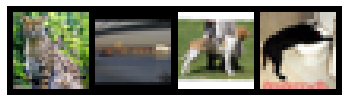

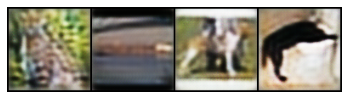

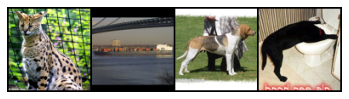

 14%|█▍        | 44/313 [03:21<21:14,  4.74s/it]

Step 670: SRResNet loss: 0.03382


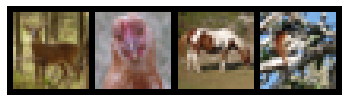

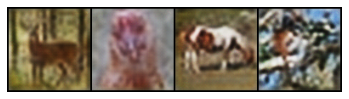

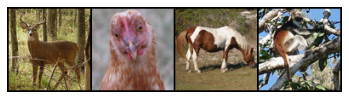

 21%|██        | 66/313 [05:01<18:08,  4.41s/it]

Step 1005: SRResNet loss: 0.03019


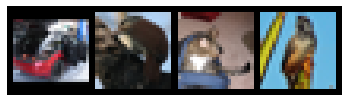

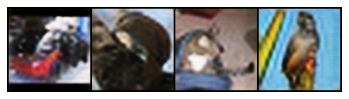

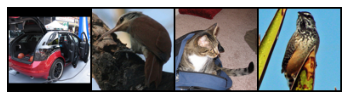

 28%|██▊       | 88/313 [06:42<17:14,  4.60s/it]

Step 1340: SRResNet loss: 0.02824


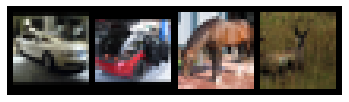

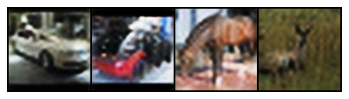

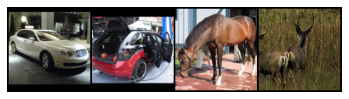

 35%|███▌      | 110/313 [08:25<16:02,  4.74s/it]

Step 1675: SRResNet loss: 0.02732


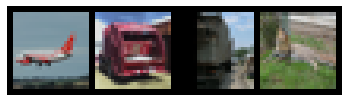

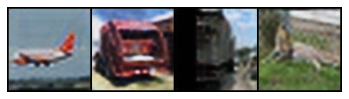

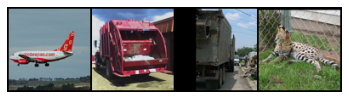

 42%|████▏     | 132/313 [10:17<13:39,  4.53s/it]

Step 2010: SRResNet loss: 0.02649


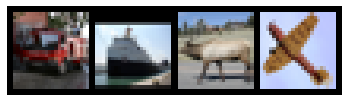

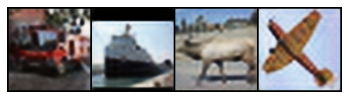

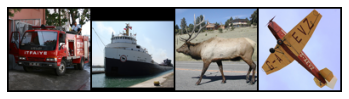

 49%|████▉     | 154/313 [11:45<12:44,  4.81s/it]

Step 2345: SRResNet loss: 0.02580


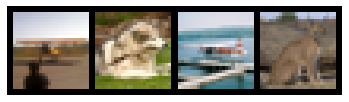

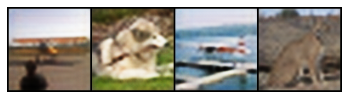

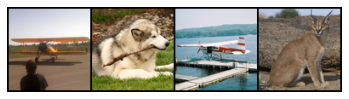

 56%|█████▌    | 176/313 [13:51<11:03,  4.85s/it]

Step 2680: SRResNet loss: 0.02523


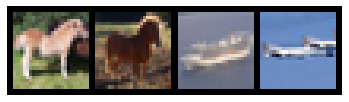

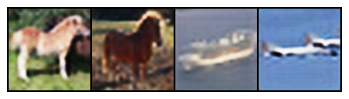

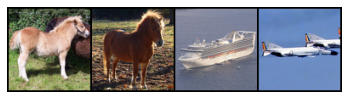

 63%|██████▎   | 198/313 [15:21<09:40,  5.04s/it]

Step 3015: SRResNet loss: 0.02482


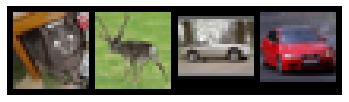

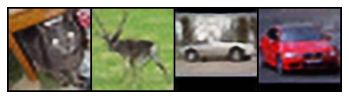

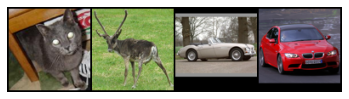

 70%|███████   | 220/313 [17:09<07:27,  4.82s/it]

Step 3350: SRResNet loss: 0.02475


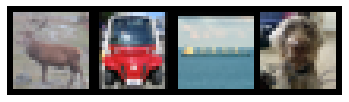

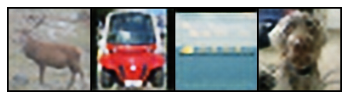

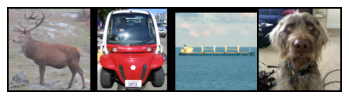

 77%|███████▋  | 242/313 [18:38<05:42,  4.82s/it]

Step 3685: SRResNet loss: 0.02428


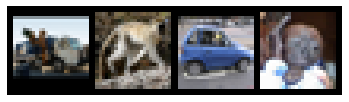

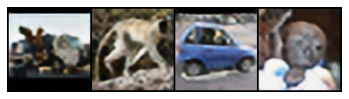

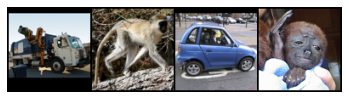

 84%|████████▍ | 264/313 [20:39<03:48,  4.67s/it]

Step 4020: SRResNet loss: 0.02376


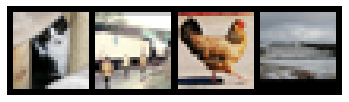

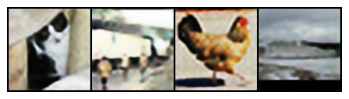

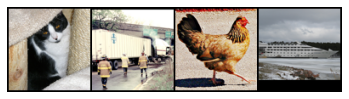

 91%|█████████▏| 286/313 [22:14<02:08,  4.77s/it]

Step 4355: SRResNet loss: 0.02348


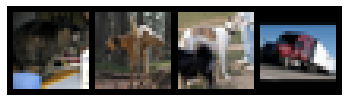

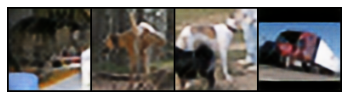

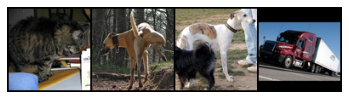

 98%|█████████▊| 308/313 [24:00<00:22,  4.57s/it]

Step 4690: SRResNet loss: 0.02342


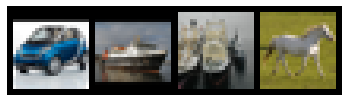

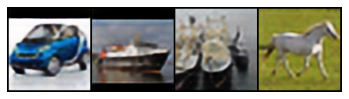

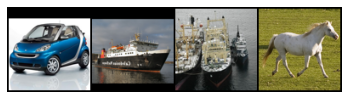

 97%|█████████▋| 304/313 [23:45<00:42,  4.69s/it]


In [ ]:
train_srresnet(generator, dataloader, device, lr=1e-4, total_steps=5000, display_step=335)
torch.save(generator, 'srresnet.pt')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

 16%|█▌        | 50/313 [15:34<1:19:58, 18.24s/it]

Step 50: Generator loss: 0.02902, Discriminator loss: 0.68649


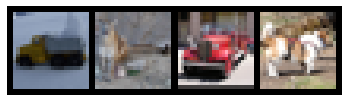

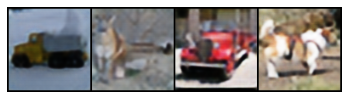

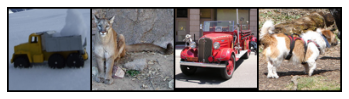

 32%|███▏      | 100/313 [31:10<1:05:08, 18.35s/it]

Step 100: Generator loss: 0.02786, Discriminator loss: 0.53534


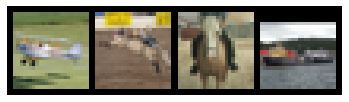

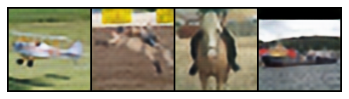

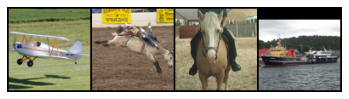

 48%|████▊     | 150/313 [46:36<50:50, 18.71s/it]

Step 150: Generator loss: 0.02764, Discriminator loss: 0.19729


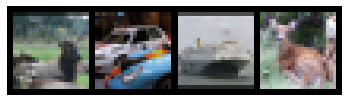

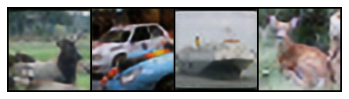

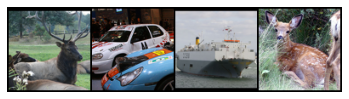

 64%|██████▍   | 200/313 [1:01:59<34:33, 18.35s/it]

Step 200: Generator loss: 0.02822, Discriminator loss: 0.05429


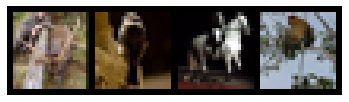

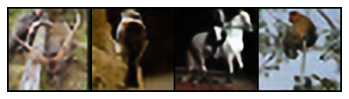

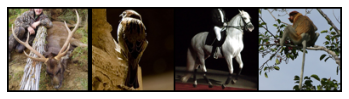

 80%|███████▉  | 250/313 [1:17:18<19:29, 18.56s/it]

Step 250: Generator loss: 0.02836, Discriminator loss: 0.02722


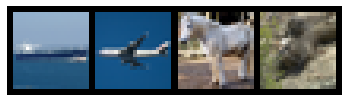

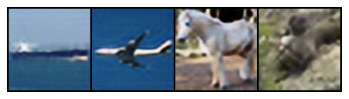

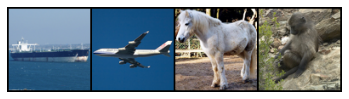

 96%|█████████▌| 300/313 [1:32:44<03:57, 18.24s/it]

Step 300: Generator loss: 0.02672, Discriminator loss: 0.01090


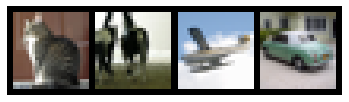

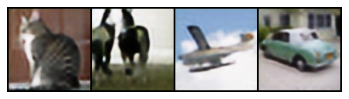

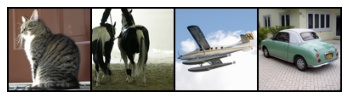

 12%|█▏        | 37/313 [11:22<1:25:54, 18.68s/it]

Step 350: Generator loss: 0.02699, Discriminator loss: 0.01020


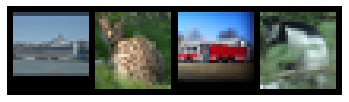

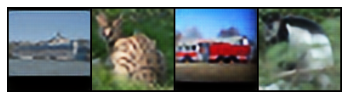

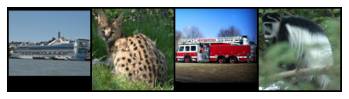

 28%|██▊       | 87/313 [26:41<1:10:10, 18.63s/it]

Step 400: Generator loss: 0.02805, Discriminator loss: 0.00447


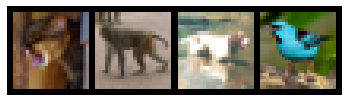

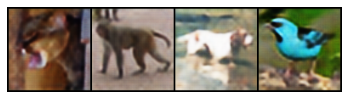

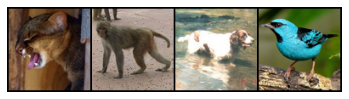

 44%|████▍     | 137/313 [42:06<54:11, 18.47s/it]

Step 450: Generator loss: 0.02785, Discriminator loss: 0.00884


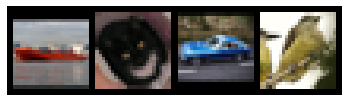

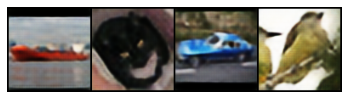

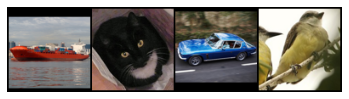

 60%|█████▉    | 187/313 [57:28<38:12, 18.19s/it]

Decayed learning rate by 10x.
Step 500: Generator loss: 0.02718, Discriminator loss: 0.00471


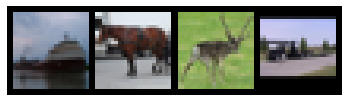

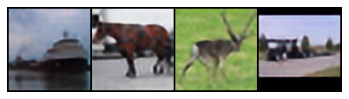

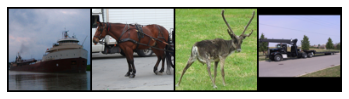

 76%|███████▌  | 237/313 [1:12:52<23:13, 18.34s/it]

Step 550: Generator loss: 0.02744, Discriminator loss: 0.00701


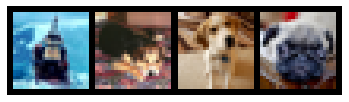

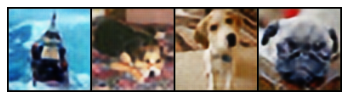

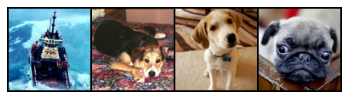

 92%|█████████▏| 287/313 [1:28:19<08:03, 18.58s/it]

Step 600: Generator loss: 0.02663, Discriminator loss: 0.00888


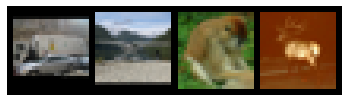

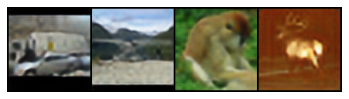

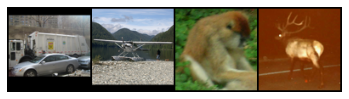

  8%|▊         | 24/313 [07:19<1:27:52, 18.24s/it]

Step 650: Generator loss: 0.02724, Discriminator loss: 0.00247


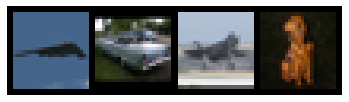

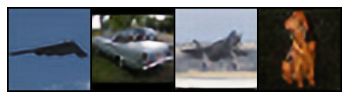

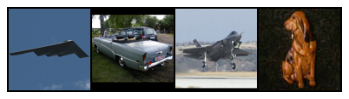

 24%|██▎       | 74/313 [22:46<1:14:11, 18.63s/it]

Step 700: Generator loss: 0.02730, Discriminator loss: 0.00210


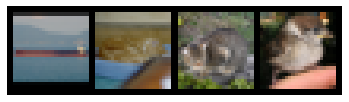

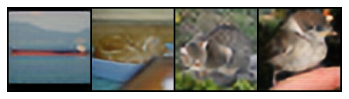

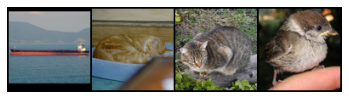

 40%|███▉      | 124/313 [38:11<59:30, 18.89s/it]

Step 750: Generator loss: 0.02732, Discriminator loss: 0.00193


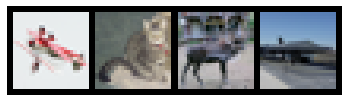

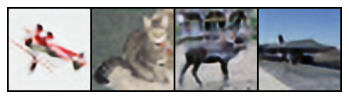

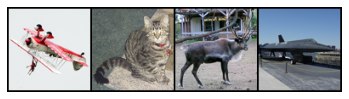

 56%|█████▌    | 174/313 [53:38<43:46, 18.90s/it]

Step 800: Generator loss: 0.02729, Discriminator loss: 0.00064


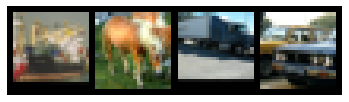

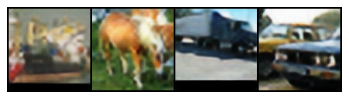

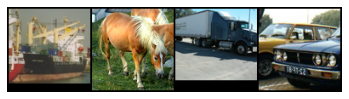

 72%|███████▏  | 224/313 [1:09:04<27:17, 18.40s/it]

Step 850: Generator loss: 0.02714, Discriminator loss: 0.00051


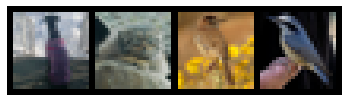

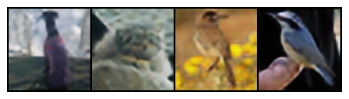

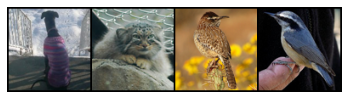

 88%|████████▊ | 274/313 [1:24:34<12:02, 18.53s/it]

Step 900: Generator loss: 0.02749, Discriminator loss: 0.00036


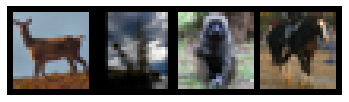

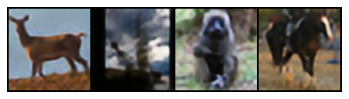

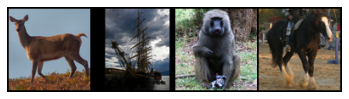

  4%|▎         | 11/313 [03:24<1:33:42, 18.62s/it]

Step 950: Generator loss: 0.02689, Discriminator loss: 0.00083


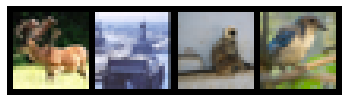

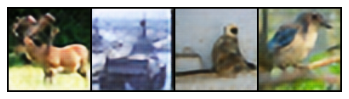

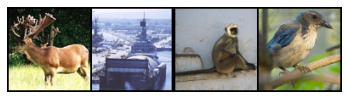

 19%|█▉        | 60/313 [18:48<1:19:17, 18.80s/it]


In [ ]:
generator = torch.load('srresnet.pt')
discriminator = Discriminator()
train_srgan(generator, discriminator, dataloader, device, lr=1e-4, total_steps=1000, display_step=50)
torch.save(generator, 'srgenerator.pt')
torch.save(discriminator, 'srdiscriminator.pt')

##Verification

In [ ]:
srresnet=torch.load('srresnet.pt')
srgan=torch.load('srgenerator.pt')

From top to bottom:lr srresnet srgan hr


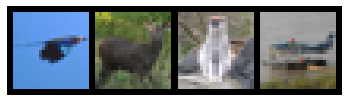

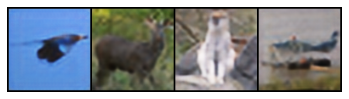

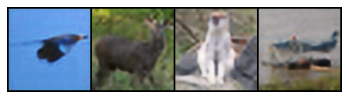

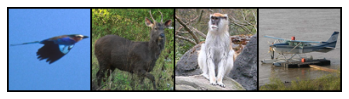

In [ ]:
# Reconstruction results and corresponding reference hr image
cur_step = 0
total_steps = 2
display_step = 1
while cur_step < total_steps:
  for hr_real, lr_real in dataloader:
    hr_real = hr_real.to(device)
    lr_real = lr_real.to(device)
    hr_srresnet=srresnet(lr_real)
    hr_srgan=srgan(lr_real)
    if cur_step % display_step == 0 and cur_step > 0:
        print('From top to bottom:lr srresnet srgan hr')
        show_tensor_images(lr_real * 2 - 1)
        show_tensor_images(hr_srresnet.to(hr_real.dtype))
        show_tensor_images(hr_srgan.to(hr_real.dtype))
        show_tensor_images(hr_real)
    cur_step += 1
    if cur_step == total_steps:
      break


In [ ]:
#PSNR METRIC
import numpy as np
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
def transpsnr(img):
  
  img=make_grid(img.detach().cpu()[:1], nrow=1)
  #3*3tensor
  img_o=img.permute(1, 2, 0).squeeze()
  img_n=img_o.numpy()

  imgtrans = img_n.astype(np.float64)
  return imgtrans



In [ ]:
num1=transpsnr(hr_real)
num2=transpsnr(hr_srresnet)
num3=transpsnr(hr_srgan)

In [ ]:
psnr_srresnet=psnr(num1,num2)
psnr_srgan=psnr(num1,num3)

print(f"psnr of srresnet is {psnr_srresnet},psnr of srgan is {psnr_srgan}")


psnr of srresnet is 70.06359599952,psnr of srgan is 70.64167788657066


In [ ]:
from skimage.metrics import structural_similarity as compare_ssim

In [ ]:
#SSIM METRIC
score = compare_ssim(num2, num1, multichannel=True)
score2 = compare_ssim(num3, num1, multichannel=True)
print(f"SSIM of srresnet is {format(score)},SSIM of srgan is {format(score2)}")

SSIM of srresnet is 0.824630790944053,SSIM of srgan is 0.8348116975747991


## Credit

### Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network

_Christian Ledig, Lucas Theis, Ferenc Huszar, Jose Caballero, Andrew Cunningham, Alejandro Acosta, Andrew Aitken, Alykhan Tejani, Johannes Totz, Zehan
Wang, Wenzhe Shi_ <br>

**Abstract** <br>
Despite the breakthroughs in accuracy and speed of single image super-resolution using faster and deeper convolutional neural networks, one central
problem remains largely unsolved: how do we recover the finer texture details when we super-resolve at large upscaling factors? The behavior of
optimization-based super-resolution methods is principally driven by the choice of the objective function. Recent work has largely focused on
minimizing the mean squared reconstruction error. The resulting estimates have high peak signal-to-noise ratios, but they are often lacking
high-frequency details and are perceptually unsatisfying in the sense that they fail to match the fidelity expected at the higher resolution. In this
paper, we present SRGAN, a generative adversarial network (GAN) for image super-resolution (SR). To our knowledge, it is the first framework capable
of inferring photo-realistic natural images for 4x upscaling factors. To achieve this, we propose a perceptual loss function which consists of an
adversarial loss and a content loss. The adversarial loss pushes our solution to the natural image manifold using a discriminator network that is
trained to differentiate between the super-resolved images and original photo-realistic images. In addition, we use a content loss motivated by
perceptual similarity instead of similarity in pixel space. Our deep residual network is able to recover photo-realistic textures from heavily
downsampled images on public benchmarks. An extensive mean-opinion-score (MOS) test shows hugely significant gains in perceptual quality using SRGAN.
The MOS scores obtained with SRGAN are closer to those of the original high-resolution images than to those obtained with any state-of-the-art method.

[[Paper]](https://arxiv.org/pdf/1609.04802v5.pdf)

```bibtex
@InProceedings{srgan,
    author = {Christian Ledig, Lucas Theis, Ferenc Huszar, Jose Caballero, Andrew Cunningham, Alejandro Acosta, Andrew Aitken, Alykhan Tejani, Johannes Totz, Zehan Wang, Wenzhe Shi},
    title = {Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network},
    booktitle = {arXiv},
    year = {2016}
}
```